In [1]:
import numpy as np
import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Select the GPU index
import scipy.io
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from PIL import Image
from collections import OrderedDict
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
from torch.optim.lr_scheduler import _LRScheduler
import warnings
import spacy
from scipy.io import savemat
import dill as pickle
import thop
from torch_challenge_dataset import DeepVerseChallengeLoaderTaskTwo
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
#Parameters
onoffdict={'GPS': False, 'CAMERAS': False, 'RADAR': False}
lr=1e-3
num_epochs=200

reduction = 4
batch_size = 200
weight_path=f'models0/CSINetplustask2/cr{reduction}/gps{onoffdict["GPS"]}_cam{onoffdict["CAMERAS"]}_rad{onoffdict["RADAR"]}/'

In [3]:
reduction

4

In [4]:
weight_path

'models0/CSINetplustask2/cr4/gpsFalse_camFalse_radFalse/'

In [5]:
if not os.path.exists(weight_path):
    os.makedirs(weight_path)

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data Analysis

In [7]:
train_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_train.csv')
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=5)
test_dataset = DeepVerseChallengeLoaderTaskTwo(csv_path = r'./dataset_validation.csv')
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=5)

# Utils and Models

In [8]:
def CSI_reshape( y, csi_std=2.5e-06, target_std=1):
        ry = torch.real(y)
        iy= torch.imag(y)
        oy=torch.cat([ry,iy],dim=1)
        #scaling
        oy=(oy/csi_std)*target_std
        return oy

In [9]:
def CSI_ri_avg(y):
    ry=y[:,0,:,:]
    iy=y[:,1,:,:]
    y = torch.sqrt(ry**2+iy**2)
    return y

In [10]:
def cal_model_parameters(model):
    total_param  = []
    for p1 in model.parameters():
        total_param.append(int(p1.numel()))
    return sum(total_param)

In [11]:
def NMSE_cal(x_hat, x):
    x_real = torch.reshape(torch.real(x), (x.shape[0], -1))
    x_imag = torch.reshape(torch.imag(x), (x.shape[0], -1))
    x_hat_real = torch.reshape(torch.real(x_hat), (x.shape[0], -1))
    x_hat_imag = torch.reshape(torch.imag(x_hat), (x.shape[0], -1))
    power = torch.sum(x_real** 2 + x_imag** 2, dim=1)
    mse = torch.sum((x_real - x_hat_real) ** 2 + (x_imag - x_hat_imag) ** 2, dim=1)
    nmse = torch.mean(mse / power)
    return nmse

In [12]:
class ConvLayer(nn.Sequential):
    def __init__(self, in_planes, out_planes, kernel_size,stride=1, activation="LeakyReLu"):
        padding = (kernel_size - 1) // 2
        dict_activation ={"LeakyReLu":nn.LeakyReLU(negative_slope=0.3,inplace=True),"Sigmoid":nn.Sigmoid(),"Tanh":nn.Tanh()}
        activation_layer = dict_activation[activation]
        super(ConvLayer, self).__init__(OrderedDict([
            ("conv", nn.Conv2d(in_planes, out_planes, kernel_size, stride, padding=padding, bias=False)),
            ("bn", nn.BatchNorm2d(out_planes)),
            ("activation",activation_layer)
        ]))

class RefineNetBlock(nn.Module):
    def __init__(self):
        super(RefineNetBlock, self).__init__()
        self.direct = nn.Sequential(OrderedDict([
            ("conv_7x7", ConvLayer(2, 8, 7, activation="LeakyReLu")),
            ("conv_5x5", ConvLayer(8, 16, 5, activation="LeakyReLu")),
            ("conv_3x3",ConvLayer(16,2,3,activation="Tanh"))
        ]))
        self.identity = nn.Identity()
        self.relu = nn.ReLU()
    def forward(self, x):
        identity = self.identity(x)
        out = self.direct(x)
        out = self.relu(out + identity)
        
        return out

In [13]:
class task2Encoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Encoder, self).__init__()
        total_size, in_channel, w, h = 8192, 2, 64, 64
        self.encoder_conv = nn.Sequential(OrderedDict([
            ("conv1_7x7", ConvLayer(2, 2, 7, activation='LeakyReLu')),
            ("conv2_7x7",ConvLayer(2,2,7,activation='LeakyReLu'))
        ]))
        self.encoder_fc = nn.Linear(total_size, total_size // reduction)
         
    
    def forward(self, x):
        n,c,h,w = x.detach().size()
        out = self.encoder_conv(x.to(torch.float32))
        out = self.encoder_fc(out.view(n, -1))
        return out
       

In [14]:
class task2Decoder(nn.Module):
    
    def __init__(self, reduction=16):
        super(task2Decoder, self).__init__()
        total_size, in_channel, w, h = 8192, 2, 64, 64
        self.decoder_fc = nn.Linear(total_size // reduction, total_size)
        self.decoder_conv = ConvLayer(2, 2, 7, activation="Sigmoid")
        self.decoder_refine = nn.Sequential(OrderedDict([
            (f"RefineNet{i+1}",RefineNetBlock()) for i in range(5)
        ]))
        self.decoder_sigmoid = nn.Sigmoid()
        
        
    def forward(self, Hencoded):
        bs = Hencoded.size(0)
        out = self.decoder_fc(Hencoded).view(bs, -1, 64, 64)
        out = self.decoder_conv(out)
        out = self.decoder_refine(out)
        
        return out

In [15]:
#complete task 2 model including encoder, decoder and channel
class task2model(nn.Module):
    def __init__(self, reduction=16):
        super().__init__()
        
        self.en=task2Encoder(reduction)
        
        self.de=task2Decoder(reduction)
        
    
   
    def forward(self, Hin, device, is_training): 
        
        #Encoder
        Hencoded=self.en(Hin)
        
        
        #Decoder   
        Hdecoded=self.de(Hencoded)
        

        return Hdecoded

In [16]:
model=task2model(reduction)
print(f'Number of parameters in Task2 Encoder: {cal_model_parameters(model.en)}')
print(f'Number of parameters in Task2 Decoder: {cal_model_parameters(model.de)}')

Number of parameters in Task2 Encoder: 16779664
Number of parameters in Task2 Decoder: 16807228


In [17]:
# Training

In [18]:
#Loss

#criterion=nn.BCELoss()
#criterion = nn.CrossEntropyLoss()
criterion= nn.MSELoss().to(device)

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#if SGDR == True:
#    sched = CosineWithRestarts(optimizer, T_max=n_batches)

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, threshold=0.00001, patience=200, verbose=True)

In [20]:
# Declare the scheduler before the training loop
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)

In [21]:
model=model.to(device)

In [22]:
start_time = time.time()
num_train_batches=len(train_loader)
num_test_batches=len(test_loader)
train_losses = []
val_losses = []

patience_counter = 0
best_val_loss = float('inf')

for i in range(num_epochs):
    loss1 = 0
    
    epoch_time = time.time()
    model.train()
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_train=y_train.to(device)
        # Apply the model
        Xin = CSI_reshape(X_train[0])
        y_pred=model(Xin.to(device), device, is_training=True)
        y_train_reshaped=CSI_reshape(y_train)
        loss = criterion(y_pred, y_train_reshaped) 
        # Update parameters
        loss.backward()
        optimizer.step()
        loss1=loss1+loss
        
            
    train_loss=loss1/num_train_batches  
    train_losses.append(train_loss.item())
    
    
   
    # Run the testing batches
    model.eval()
    with torch.no_grad():
        loss1=0 
        nmse1=0
        for b, (X_test, y_test) in enumerate(test_loader):
            y_test=y_test.to(device)
            # Apply the model
            Xin = CSI_reshape(X_test[0])
            y_pred=model(Xin.to(device), device, is_training=True)
            y_test_reshaped=CSI_reshape(y_test)
            loss = criterion(y_pred, y_test_reshaped) 
            loss1=loss1+loss  
            
        val_loss=loss1/num_test_batches 
        scheduler.step(val_loss)
        val_losses.append(val_loss.item())
    print(f'epoch:{i+1}/{num_epochs} average reshaped TL:{train_loss.item():10.8f} average reshaped VL:{val_loss.item():10.8f} epoch time:{time.time() - epoch_time:.0f} seconds, lr:{optimizer.param_groups[0]["lr"]:.2e}')               
        # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model, weight_path+"task2.pth")
        torch.save(model.en, weight_path+"task2Encoder.pth")
        torch.save(model.de, weight_path+"task2Decoder.pth")

print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:1/200 average reshaped TL:1.22984827 average reshaped VL:1.11224604 epoch time:418 seconds, lr:1.00e-03
epoch:2/200 average reshaped TL:1.02640200 average reshaped VL:1.08430636 epoch time:383 seconds, lr:1.00e-03
epoch:3/200 average reshaped TL:1.02093506 average reshaped VL:1.12113428 epoch time:376 seconds, lr:1.00e-03
epoch:4/200 average reshaped TL:1.02088559 average reshaped VL:1.08677399 epoch time:346 seconds, lr:1.00e-03
epoch:5/200 average reshaped TL:1.02061510 average reshaped VL:1.07038283 epoch time:344 seconds, lr:1.00e-03
epoch:6/200 average reshaped TL:1.02005756 average reshaped VL:1.09430504 epoch time:349 seconds, lr:1.00e-03
epoch:7/200 average reshaped TL:1.01762450 average reshaped VL:1.09103537 epoch time:347 seconds, lr:1.00e-03
epoch:8/200 average reshaped TL:1.01014364 average reshaped VL:1.06391501 epoch time:347 seconds, lr:1.00e-03
epoch:9/200 average reshaped TL:1.00812161 average reshaped VL:1.05285811 epoch time:348 seconds, lr:1.00e-03
epoch:10/2

epoch:75/200 average reshaped TL:0.69124115 average reshaped VL:0.87760246 epoch time:349 seconds, lr:5.00e-04
epoch:76/200 average reshaped TL:0.69110364 average reshaped VL:0.86186719 epoch time:347 seconds, lr:5.00e-04
epoch:77/200 average reshaped TL:0.68968296 average reshaped VL:0.87101203 epoch time:347 seconds, lr:5.00e-04
epoch:78/200 average reshaped TL:0.68874663 average reshaped VL:0.87593770 epoch time:352 seconds, lr:5.00e-04
epoch:79/200 average reshaped TL:0.68782914 average reshaped VL:0.89677531 epoch time:344 seconds, lr:5.00e-04
epoch:80/200 average reshaped TL:0.68723804 average reshaped VL:0.87584478 epoch time:343 seconds, lr:5.00e-04
epoch:81/200 average reshaped TL:0.68646097 average reshaped VL:0.88021094 epoch time:347 seconds, lr:5.00e-04
epoch:82/200 average reshaped TL:0.68599957 average reshaped VL:0.86888230 epoch time:346 seconds, lr:5.00e-04
epoch:83/200 average reshaped TL:0.68492723 average reshaped VL:0.86263484 epoch time:350 seconds, lr:5.00e-04
e

epoch:149/200 average reshaped TL:0.65828127 average reshaped VL:0.89980417 epoch time:353 seconds, lr:3.13e-05
epoch:150/200 average reshaped TL:0.65737063 average reshaped VL:0.89556873 epoch time:348 seconds, lr:3.13e-05
epoch:151/200 average reshaped TL:0.65741068 average reshaped VL:0.88460505 epoch time:345 seconds, lr:3.13e-05
epoch:152/200 average reshaped TL:0.65744025 average reshaped VL:0.90660274 epoch time:347 seconds, lr:3.13e-05
epoch:153/200 average reshaped TL:0.65694129 average reshaped VL:0.90977687 epoch time:366 seconds, lr:3.13e-05
epoch:154/200 average reshaped TL:0.65735310 average reshaped VL:0.89494586 epoch time:348 seconds, lr:3.13e-05
epoch:155/200 average reshaped TL:0.65710783 average reshaped VL:0.88309932 epoch time:348 seconds, lr:3.13e-05
epoch:156/200 average reshaped TL:0.65688872 average reshaped VL:0.91779351 epoch time:343 seconds, lr:3.13e-05
epoch:157/200 average reshaped TL:0.65667427 average reshaped VL:0.91645461 epoch time:355 seconds, lr:3

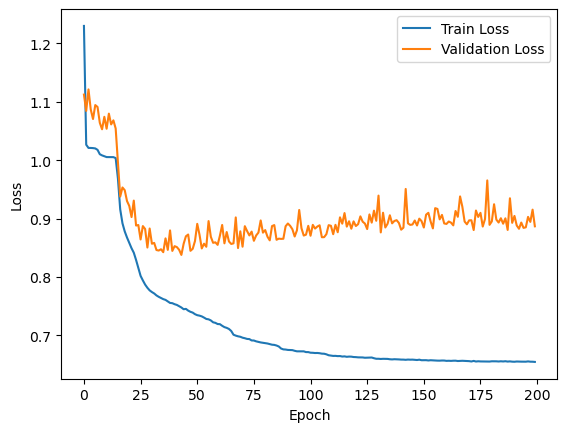

In [23]:
# Plotting
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
flops, params = thop.profile(model, inputs=(Xin.to(device), device, True, ), verbose=False)
print(f'Model Flops: {flops}')
print(f'Model Params Num: {params}\n')

Model Flops: 12568166400.0
Model Params Num: 33586892.0



In [25]:
np.save(weight_path+'train_loss.npy', train_losses)
np.save(weight_path+'val_loss.npy', val_losses)

# Inference

In [26]:
#Create an instance of your model
#model = task2model()

model2=torch.load(weight_path+"task2.pth").to(device)
# Run the testing batches
model2.eval()
with torch.no_grad():
    mse1=0
    for b, (X_test, y_test) in enumerate(test_loader):

        y_test=y_test.to(device)
        # Apply the model
        Xin = CSI_reshape(X_test[0])
        y_pred=model2(Xin.to(device), device, is_training=False)
        y_test_reshaped = CSI_reshape(y_test)
        mse0 = criterion(CSI_ri_avg(y_pred), CSI_ri_avg(y_test_reshaped))
        mse1+=mse0 
        
    avg_mse=mse1/num_test_batches

In [27]:
print(f'Average MSE:{avg_mse}')


Average MSE:1.2751551866531372


In [28]:
h_list = torch.tensor([])
for b, (x,h) in enumerate(test_loader):
    h = CSI_ri_avg(CSI_reshape(h))
    h_list = torch.cat([h_list,h])
target_loss = torch.mean((torch.abs(h_list) - torch.mean(torch.abs(h_list))) ** 2)

In [29]:
improvement = (target_loss.item() - avg_mse) / target_loss.item() * 100
print(f'Percentage Improvement Achieved: {improvement:.4f}%')

Percentage Improvement Achieved: 9.6567%


In [30]:
target_loss

tensor(1.4115)